In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def use_gpu():
    torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() 
                                                         else torch.FloatTensor)
use_gpu()

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-07-01 20:27:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 74.125.128.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   123MB/s    in 0.5s    

2020-07-01 20:27:31 (123 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('tmp')
zip_ref.close()

In [ ]:
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.767.jpg', 'cat.332.jpg', 'cat.695.jpg', 'cat.456.jpg', 'cat.24.jpg', 'cat.161.jpg', 'cat.195.jpg', 'cat.370.jpg', 'cat.387.jpg', 'cat.244.jpg']
['dog.565.jpg', 'dog.356.jpg', 'dog.612.jpg', 'dog.762.jpg', 'dog.263.jpg', 'dog.143.jpg', 'dog.713.jpg', 'dog.309.jpg', 'dog.213.jpg', 'dog.836.jpg']


In [ ]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

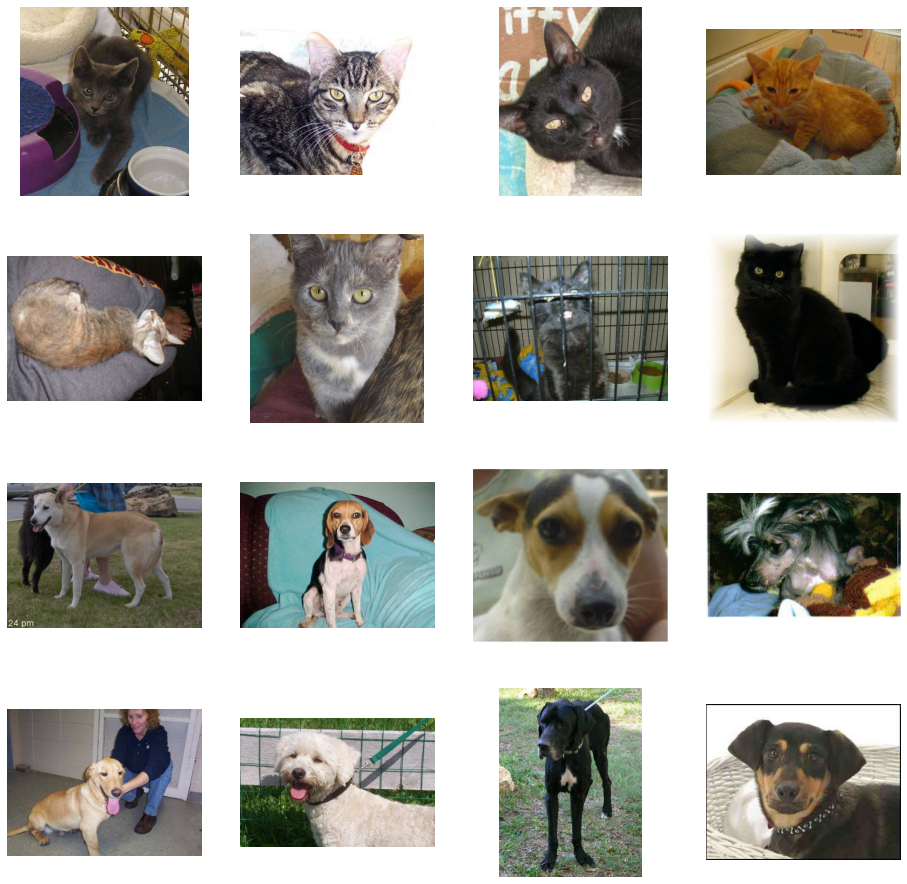

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {}, Loss: {:.3f}'.format(epoch, loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, pred = output.max(1)
            test_loss += criterion(output, target).item() 
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader.dataset)

    print('Average loss: {:.3f}, Test Acc: {:.3f} ({}/{})'.format(test_loss, 100.*correct/total, correct, total))


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16  , kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2))

        self.fc1 = nn.Linear(in_features=74*74*32, out_features=300)
        self.fc2 = nn.Linear(in_features=300, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=2)
        self.flatten = nn.Flatten()
        
        
    def forward(self, X):
        if torch.cuda.is_available():
            X = X.to(device="cuda")
        X = F.relu(self.conv1(X))        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        #dropout1
        X = self.flatten(X)

        X = F.relu(self.fc1(X))
        #dropout2
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return X

In [ ]:
batch_size = 100
test_batch_size = 50
epochs = 15
lr = 1e-3
criterion = nn.CrossEntropyLoss()

In [ ]:
trainset = datasets.ImageFolder(train_dir,transform=transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()]))
valset = datasets.ImageFolder(validation_dir, transform=transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset,batch_size=test_batch_size, shuffle=False)

In [ ]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, val_loader)

Train Epoch: 1, Loss: 0.682
Average loss: 0.015, Test Acc: 50.000 (500/1000)
Train Epoch: 2, Loss: 0.618
Average loss: 0.014, Test Acc: 53.800 (538/1000)
Train Epoch: 3, Loss: 0.687
Average loss: 0.013, Test Acc: 60.600 (606/1000)
Train Epoch: 4, Loss: 0.643
Average loss: 0.013, Test Acc: 60.300 (603/1000)
Train Epoch: 5, Loss: 0.583
Average loss: 0.013, Test Acc: 63.500 (635/1000)
Train Epoch: 6, Loss: 0.495
Average loss: 0.012, Test Acc: 68.500 (685/1000)
Train Epoch: 7, Loss: 0.451
Average loss: 0.013, Test Acc: 67.900 (679/1000)
Train Epoch: 8, Loss: 0.276
Average loss: 0.014, Test Acc: 63.800 (638/1000)
Train Epoch: 9, Loss: 0.474
Average loss: 0.014, Test Acc: 65.300 (653/1000)
Train Epoch: 10, Loss: 0.150
Average loss: 0.017, Test Acc: 64.500 (645/1000)
Train Epoch: 11, Loss: 0.151
Average loss: 0.017, Test Acc: 64.300 (643/1000)
Train Epoch: 12, Loss: 0.096
Average loss: 0.018, Test Acc: 64.300 (643/1000)
Train Epoch: 13, Loss: 0.045
Average loss: 0.023, Test Acc: 62.300 (623/1

## Your task: play with the network architecture and try to achieve higher accuracy!
### Hint:
- You may need more convolutional layers
- You may need more/different regularization layers (batch norm/dropout)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2, 2))

        self.fc1 = nn.Linear(in_features=17*17*64, out_features=300)
        self.fc2 = nn.Linear(in_features=300, out_features=2)
        
        self.bn_conv = nn.BatchNorm2d(32)
        self.bn_fc = nn.BatchNorm1d(300)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        
        
    def forward(self, X):
        if torch.cuda.is_available():
            X = X.to(device="cuda")
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.bn_conv(self.conv2(X)))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = self.flatten(X)

        X = F.relu(self.bn_fc(self.fc1(X)))
        X = self.dropout(X)
        X = self.fc2(X)
        
        return X

In [ ]:
batch_size = 100
test_batch_size = 50
epochs = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()

In [ ]:
trainset = datasets.ImageFolder(train_dir,transform=transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()]))
valset = datasets.ImageFolder(validation_dir, transform=transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=test_batch_size, shuffle=False)

In [ ]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, val_loader)

Train Epoch: 1, Loss: 0.590
Average loss: 0.020, Test Acc: 50.000 (500/1000)
Train Epoch: 2, Loss: 0.513
Average loss: 0.016, Test Acc: 50.600 (506/1000)
Train Epoch: 3, Loss: 0.373
Average loss: 0.023, Test Acc: 52.400 (524/1000)
Train Epoch: 4, Loss: 0.202
Average loss: 0.012, Test Acc: 71.400 (714/1000)
Train Epoch: 5, Loss: 0.101
Average loss: 0.012, Test Acc: 71.900 (719/1000)
Train Epoch: 6, Loss: 0.068
Average loss: 0.012, Test Acc: 73.000 (730/1000)
Train Epoch: 7, Loss: 0.019
Average loss: 0.018, Test Acc: 68.800 (688/1000)
Train Epoch: 8, Loss: 0.016
Average loss: 0.015, Test Acc: 71.400 (714/1000)
Train Epoch: 9, Loss: 0.011
Average loss: 0.017, Test Acc: 71.300 (713/1000)
Train Epoch: 10, Loss: 0.005
Average loss: 0.015, Test Acc: 74.000 (740/1000)
Train Epoch: 11, Loss: 0.005
Average loss: 0.015, Test Acc: 74.700 (747/1000)
Train Epoch: 12, Loss: 0.004
Average loss: 0.015, Test Acc: 74.700 (747/1000)
Train Epoch: 13, Loss: 0.002
Average loss: 0.016, Test Acc: 73.900 (739/1

In [ ]:
# Data augmentation
trainset = datasets.ImageFolder(train_dir,transform=transforms.Compose([transforms.Resize((150, 150)), 
                                                                        transforms.RandomHorizontalFlip(p=0.5), 
                                                                        transforms.ColorJitter(brightness=0.5, contrast=0.5), 
                                                                        transforms.RandomRotation(10), 
                                                                        
                                                                        transforms.ToTensor()]))

valset = datasets.ImageFolder(validation_dir, transform=transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=test_batch_size, shuffle=False)

In [ ]:
epochs=35
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, val_loader)

Train Epoch: 1, Loss: 0.678
Average loss: 0.015, Test Acc: 50.000 (500/1000)
Train Epoch: 2, Loss: 0.627
Average loss: 0.015, Test Acc: 50.500 (505/1000)
Train Epoch: 3, Loss: 0.679
Average loss: 0.014, Test Acc: 56.400 (564/1000)
Train Epoch: 4, Loss: 0.517
Average loss: 0.012, Test Acc: 69.500 (695/1000)
Train Epoch: 5, Loss: 0.571
Average loss: 0.011, Test Acc: 70.700 (707/1000)
Train Epoch: 6, Loss: 0.509
Average loss: 0.012, Test Acc: 68.200 (682/1000)
Train Epoch: 7, Loss: 0.461
Average loss: 0.011, Test Acc: 70.900 (709/1000)
Train Epoch: 8, Loss: 0.472
Average loss: 0.011, Test Acc: 71.800 (718/1000)
Train Epoch: 9, Loss: 0.467
Average loss: 0.012, Test Acc: 70.100 (701/1000)
Train Epoch: 10, Loss: 0.421
Average loss: 0.011, Test Acc: 72.400 (724/1000)
Train Epoch: 11, Loss: 0.435
Average loss: 0.012, Test Acc: 70.200 (702/1000)
Train Epoch: 12, Loss: 0.421
Average loss: 0.011, Test Acc: 72.700 (727/1000)
Train Epoch: 13, Loss: 0.460
Average loss: 0.013, Test Acc: 69.600 (696/1